## Tutorial #3: Baseline Correction

As EEG is a time-resolving signal, it may often have temporal drifts which are unrelated to our experimental question. Various internal and external sources may cause temporal drifts, which change over time, and also across electrodes.
To reduce the effect of such drifts, it is custom to perform a so-called baseline correction. Essentially, this consists of using EEG activity over a baseline period, i.e. before an external event occurs, to correct activity over a post-stimulus interval, i.e. the time after an external event occurs.
Various approaches exist for baseline correction. The traditional way is subtracting the mean of a baseline period from every time point of the baseline and post-stimulus interval. In other words, the average voltage values of each electrode are calculated within a time interval and then this average is substracted from that time interval of the signal.

### Baseline Correction In Practice:

#### 1.) Baseline Correction with MNE
To apply baseline correction in MNE, a time interval should be passed as a paramenter to apply_baseline() function of epochs object. If 'None' is given as time interval, baseline correction will not be applied. To apply baseline correction to the all time interval, (None,None) should be used. This function returns baseline-corrected epochs object and note that it modifies the object as well. 

In [2]:
import mne
import mne.viz
import numpy as np
%matplotlib inline

In [10]:
#Load epoched data
data_file = '../../study1/study1_eeg/epochdata/P-04'
# Read the EEG epochs:
epochs = mne.read_epochs(data_file + '.fif')
epochs = epochs['FU', 'FN', 'FP']

Reading ../../study1/study1_eeg/epochdata/P-04.fif ...
    Found the data of interest:
        t =       0.00 ...    1496.09 ms
        0 CTF compensation matrices available
524 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated


<ipython-input-10-a176eba95c06>:4: RuntimeWarning: This filename (../../study1/study1_eeg/epochdata/P-04.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs = mne.read_epochs(data_file + '.fif')


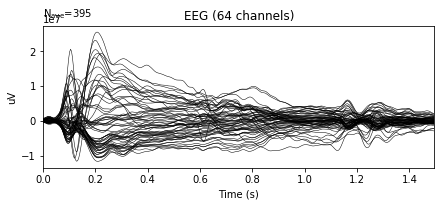

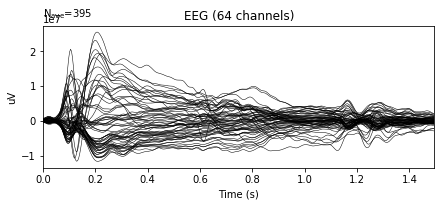

In [11]:
# Plot of initial evoked object
epochs.average().plot()

As mentioned before, the initial signal will be modified by baseline correction. If you want to keep the initial epoch object without any change it should be copied to another variable before calling apply_baseline() function. Otherwise it will be lost. In python, shallow copies can be modified when the original object is modified. However, deep copies are independent from the original object. So, in our case we need a deep copy of epochs object.

Applying baseline correction (mode: mean)


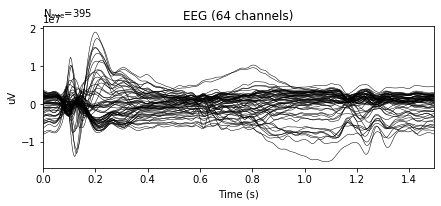

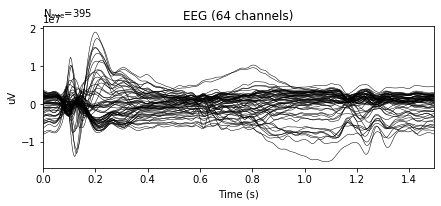

In [12]:
import copy
epochs_wo_bc = copy.deepcopy(epochs)
# baseline correction
inteval = (None, 0.2)
bc_epochs = epochs.apply_baseline(inteval)

# Plot of baseline-corrected evoked signal
bc_epochs.average().plot()

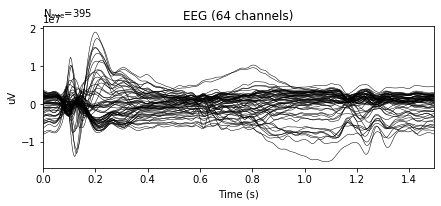

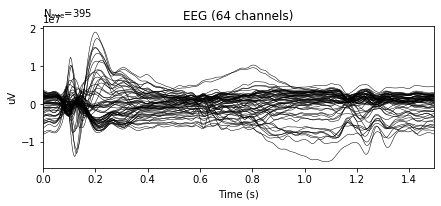

In [13]:
#Modified evoked object
epochs.average().plot()

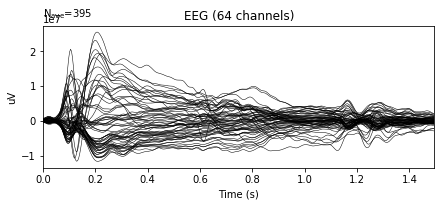

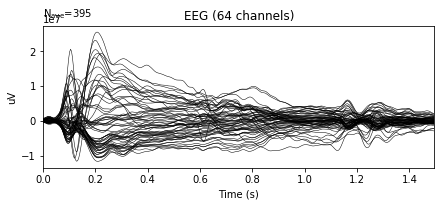

In [14]:
epochs_wo_bc.average().plot()

In the example above, the variance in the amplitudes of given signal decreased significantly.  

Alternatively a similar observation can be made via plots that show single trials and the average as in the plots below. In these plots black line represents the average and the rest is single trials. 

Note that these plots are drawn by using Matplotlib library of Python.

In [15]:
from matplotlib import pyplot as plt
%matplotlib inline

def plotChannel(ch_index, with_baselineCorrection, without_baselineCorrection):

    ch = ch_index 
    data_types = ['original', 'bc']

    for i in range(len(data_types)):

        fig, ax = plt.subplots(figsize=(20, 10))
        ax.set_xlabel('Time instances')
        ax.set_ylabel('Volt')
        #plt.ylim(-1.1, 1.5) 
        if data_types[i] == 'bc': 
            plt.title('Plot of Single Trials with Baseline Correction')
            for i in range(len(with_baselineCorrection.get_data())):   
                ax.plot(with_baselineCorrection.times, with_baselineCorrection.get_data()[i,ch,:])
            ax.plot(with_baselineCorrection.average().times, with_baselineCorrection.average().data[ch,:], color='black', label='Average of Trials')

        else:
            plt.title('Plot of Single Trials without Baseline Correction')
            for i in range(len(without_baselineCorrection.get_data())):   
                ax.plot(without_baselineCorrection.times, without_baselineCorrection.get_data()[i,ch,:])
            ax.plot(without_baselineCorrection.average().times, without_baselineCorrection.average().data[ch,:], color='black', label='Average of Trials')

        legend = ax.legend(loc='upper center', shadow=True, fontsize='large')
        plt.show()

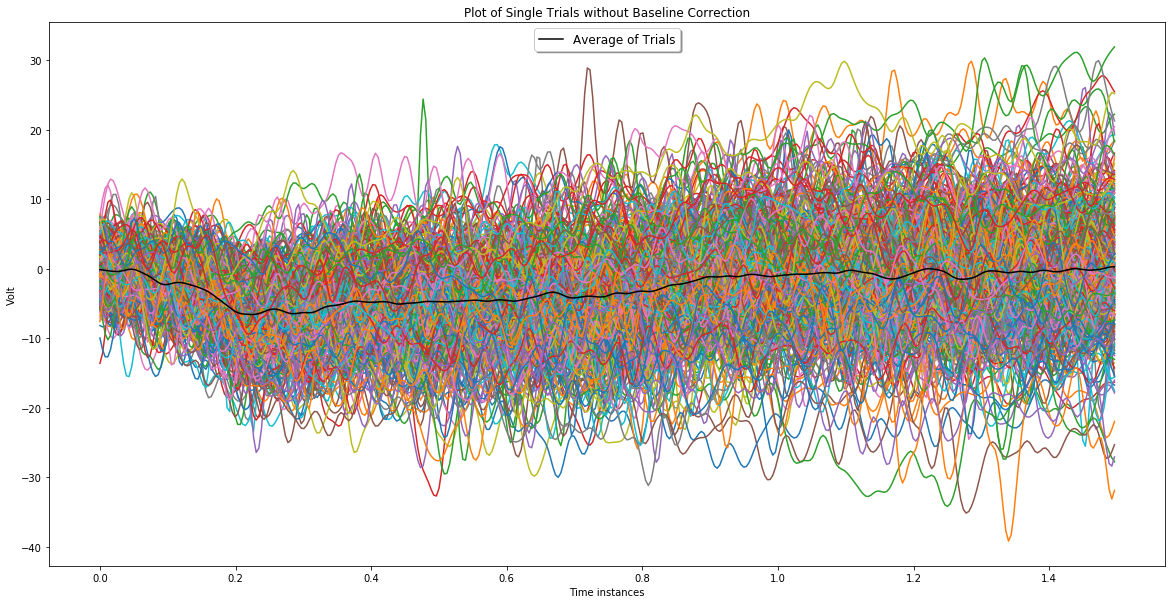

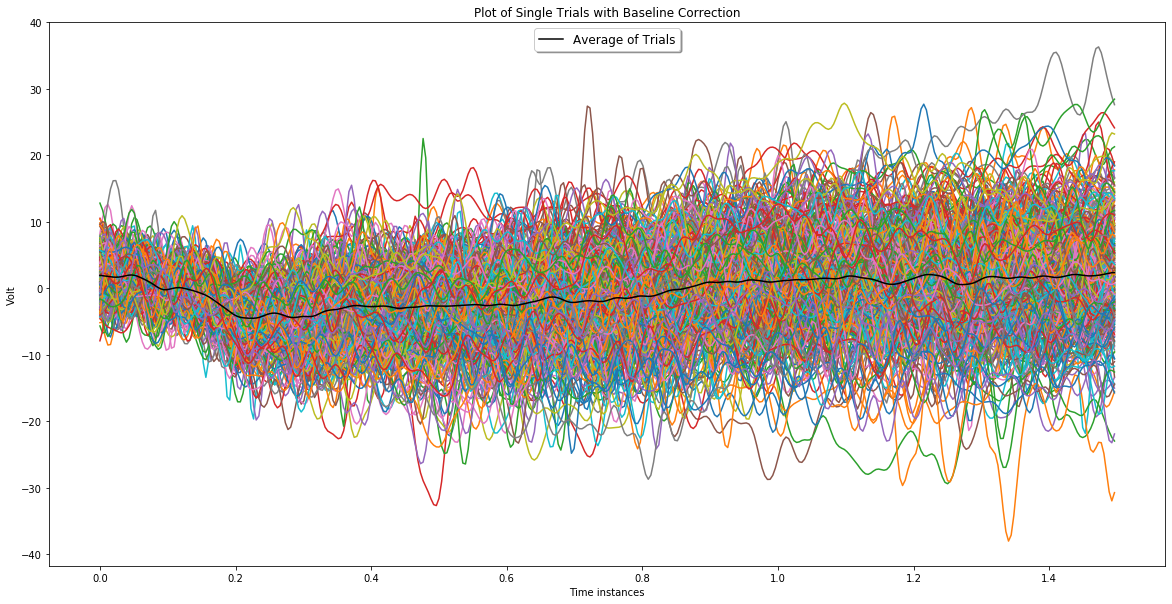

In [16]:
ch_index = 2
plotChannel(ch_index, bc_epochs, epochs_wo_bc)

In the above plot, the effect of baseline correction seems to be not significant but if you have a closer look at the largest peak on upper right corner, you will see the difference. The reason for not having an obvious change is that the ERP which is the mean of epoches is not very strong since the dataset is already baseline corrected by the authors. If we have a stronger ERP signal, then difference between two plots would be clearer.

#### 2.) Manual Baseline Correction

Altough baseline correction is avaible in MNE, it can be easily applied manually without depending on any library or package.

In [17]:
epochs_for_bc = copy.deepcopy(epochs_wo_bc)

Firstly, select a time interval for baseline calculation. For each epoch calculate the mean of selected time interval. By doing that we have the baseline values for each epoch in the dataset. 

In [18]:
time_interval = [0,0.2]
interval_baseline = [i for i in epochs_for_bc.times if i >= time_interval[0] and i <= time_interval[1]]
baseline = []
data = epochs_for_bc.get_data()
for e in range(data.shape[0]):
    avg_epoch = np.mean(data[e,:,:len(interval_baseline)], axis=1)
    baseline.append(avg_epoch)
baseline = np.asarray(baseline)

The last step of baseline correction is to subtract baseline values calculated for each epoch from epoch data.

In [19]:
for e in range(len(epochs_for_bc.get_data())):
    for i in range(len(epochs_for_bc.ch_names)):   
        epochs_for_bc.get_data()[e,i,:] = epochs_for_bc.get_data()[e,i,:] - baseline[e,i]

Plot channel 3 before and after applying baseline correction.

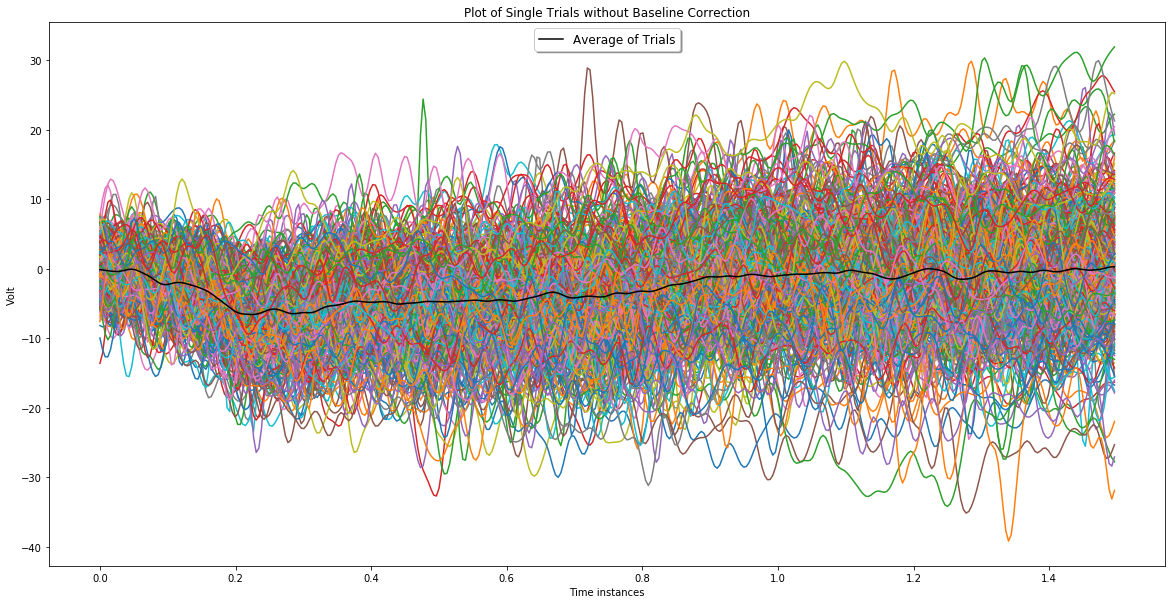

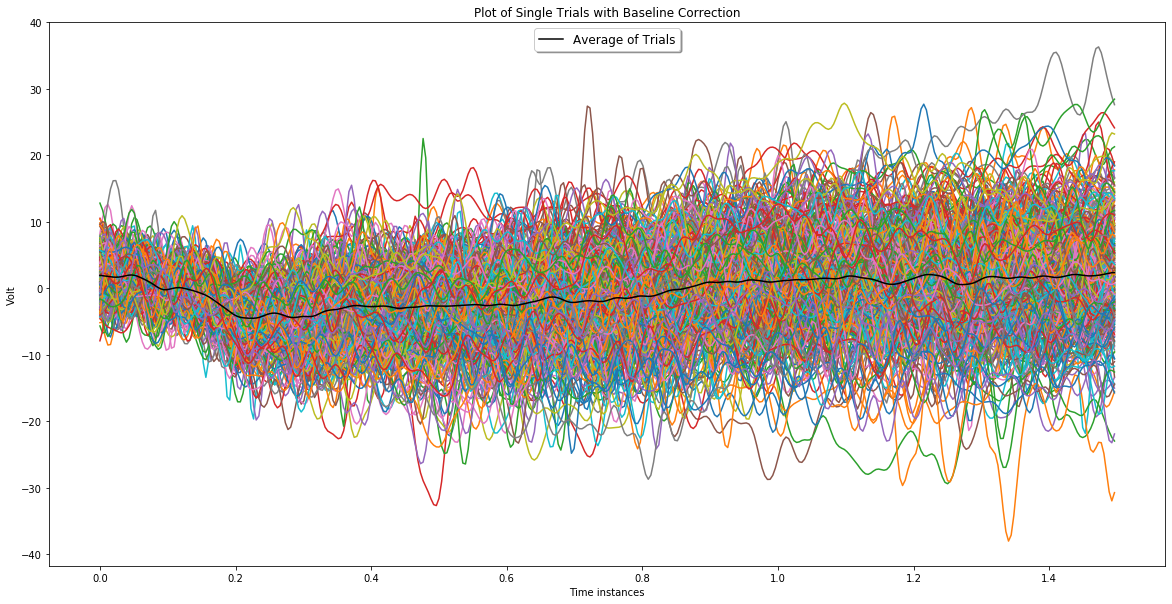

In [20]:
plotChannel(ch_index, epochs_for_bc, epochs_wo_bc)

To check wether the manual baseline calculation is correct, select an epoch as in the example below and subtract baseline corrected epoch data from epoch data before applying baseline correction for both mne and manual baseline correction. As the results, we will get an array of baseline values for both approach. Finally compare the baseline values. If all baseline values are the same, we can conclude that our calculation is correct. 

In [21]:
manual_baseline_values = np.subtract(epochs_wo_bc._data[1,:,:], epochs_for_bc._data[1,:,:])
mne_baseline_values = np.subtract(epochs_wo_bc._data[1,:,:], bc_epochs._data[1,:,:])

if manual_baseline_values.all() == mne_baseline_values.all():
    print('Baseline values calculated manually and via MNE are the same !!!')
else:
    print('Baseline values are different !!!')

Baseline values calculated manually and via MNE are the same !!!


MNE provides apply_baseline function with the method of subtracting mean of baseline interval from data. Therefore, the same method is followed for manual baseline correction in this tutorial. However, it is worth noting that there are other approaches developed for baseline correction.

Moreover, the choice of baseline interval is usually prestimulus to stimulus onset interval. However we selected [0, 0.2] as the interval. The reason is, as stated before, the dataset we are using is already baseline corrected with an interval of -100 to 0 ms relative to stimulus onset and only post stimulus portion is exported as the dataset. For more detail please check https://zenodo.org/record/197404#.Xe4tDi2ZNBy. 

##### Exercise: 
1) Change the time interval and reapply baseline correction. Do you see any difference?

2) Check other baseline corection methods and try to apply one of them.